# Responsible AI

Responsible AI is the practice of developing and deploying AI systems in a manner that prioritises ethical considerations, fairness, transparency, accountability, and the overall well-being of individuals and society. 

There are a range of techniques that can be employed to do this. This notebook provides examples of how models can be developed so that they are fair and transparent. 

## Data

In this notebook we will use the COMPAS dataset to demonstrate how bias in models can be identified and how more transparent models without this bias can be trained.

The COMPAS dataset contains information on over 10,000 defendants assessed using the COMPAS tool in Broward County, Florida, between 2013 and 2014. It includes demographic data, criminal history, and details about prior offenses, aiming to predict the likelihood of recidivism. However, concerns have been raised regarding fairness and bias in the COMPAS predictions, as studies have shown disparities across racial and ethnic groups. It therefore provides a good basis for demonstrating how bias in datasets can be identified and mitigated.

The COMPAS data used was obtained from ProPublica at https://github.com/propublica/compas-analysis.

In [ ]:
import pandas as pd

# load conpas data and view columns
compas_df = pd.read_csv("compas.csv")

#filter to recidivism only
compas_rec_df = compas_df[compas_df['type_of_assessment'] == "Risk of Recidivism"]

#load person data
person_df = pd.read_csv("person.csv")

#view first rows
pd.set_option('display.max_columns', None)

## Removing Bias

AI systems can inadvertently perpetuate biases present in the data they are trained on, leading to unfair or discriminatory outcomes. To address this issue, it is essential to actively identify and mitigate bias in AI models.

Fairlearn (https://fairlearn.org/) is an open-source community driven project that helps improve fairness in AI systems. It does this by providing a toolkit that allows users to assess for bias in machine learning models through various metrics and through applying algorithms to trained models to mitigate bias that might be present.

Below we will use Fairlearn to identify bias in the predictions made by COMPAS.

In [1]:
#import necessary libraries
import fairlearn
import sklearn

# create a df to test fairness of predictions
fairness_test_df = person_df[['race', 'decile_score', 'is_recid']]

#filter out rows with unknown recidivism
fairness_test_df = fairness_test_df[fairness_test_df['is_recid'] != -1]

#function to set recidivism prediction based on compas decile score
# 1-5 = not recidivate coded as 0
# 6-10 = recidivate coded as 1

def compas_pred(decile_score):
    if 0 <= decile_score <= 5:
        return 0
    else:
        return 1
    
#apply function
fairness_test_df['compas_pred'] = fairness_test_df.apply(lambda x: compas_pred(x['decile_score']), axis=1)

#drop decile score
fairness_test_df = fairness_test_df.drop('decile_score', axis=1)

#view dataframe
fairness_test_df.head()

We will use Fairlearn to test for two key metrics that can help us understand if there is bias in the predictions made by the COMPAS model: equalised odds and false positive rate.

*Equalised Odds* is a metric that tests whether a prediction model provides similar accuracy for different groups. 

*False positive rate* is...

In [25]:
#import fairlearn fairness assessment libraries

from fairlearn.metrics import MetricFrame
from fairlearn.metrics import count, false_positive_rate, true_positive_rate, equalized_odds_difference

y_true = fairness_test_df['is_recid']
y_pred = fairness_test_df['compas_pred']
sf_data = fairness_test_df['race']

#common metrics
metrics = {
    'fpr' : false_positive_rate,
    'tpr' : true_positive_rate,
    'count' : count
}

metric_frame = MetricFrame(
    metrics=metrics,
    y_true = y_true,
    y_pred = y_pred,
    sensitive_features = sf_data
)


#equalised odds
eq_odds = equalized_odds_difference(y_true, y_pred,sensitive_features=sf_data)

Examining equalised odds can give a quick indication if there is bias in outcomes.

In [29]:
eq_odds

0.5224775224775225

Equalised odds here calculates the difference in rates between groups and reports the biggest difference. This large equalised odds score indicates bias in the dataset. Checking the entire frame will illuminate where this is.

In [26]:
metric_frame.by_group

,fpr,tpr,count
race,,,
African-American,0.400782,0.618391,5501.0
Asian,0.071429,0.545455,53.0
Caucasian,0.179919,0.392103,3818.0
Hispanic,0.159091,0.325670,1009.0
Native American,0.217391,0.769231,36.0
Other,0.109208,0.246753,621.0


Equalised odds is reporting the difference in true positives rates between Native American and 'Other'. However we see significant disparity across both false positive and true positive rates that represent prolematic bias.

array([[<Axes: title={'center': 'fpr'}, xlabel='race'>]], dtype=object)

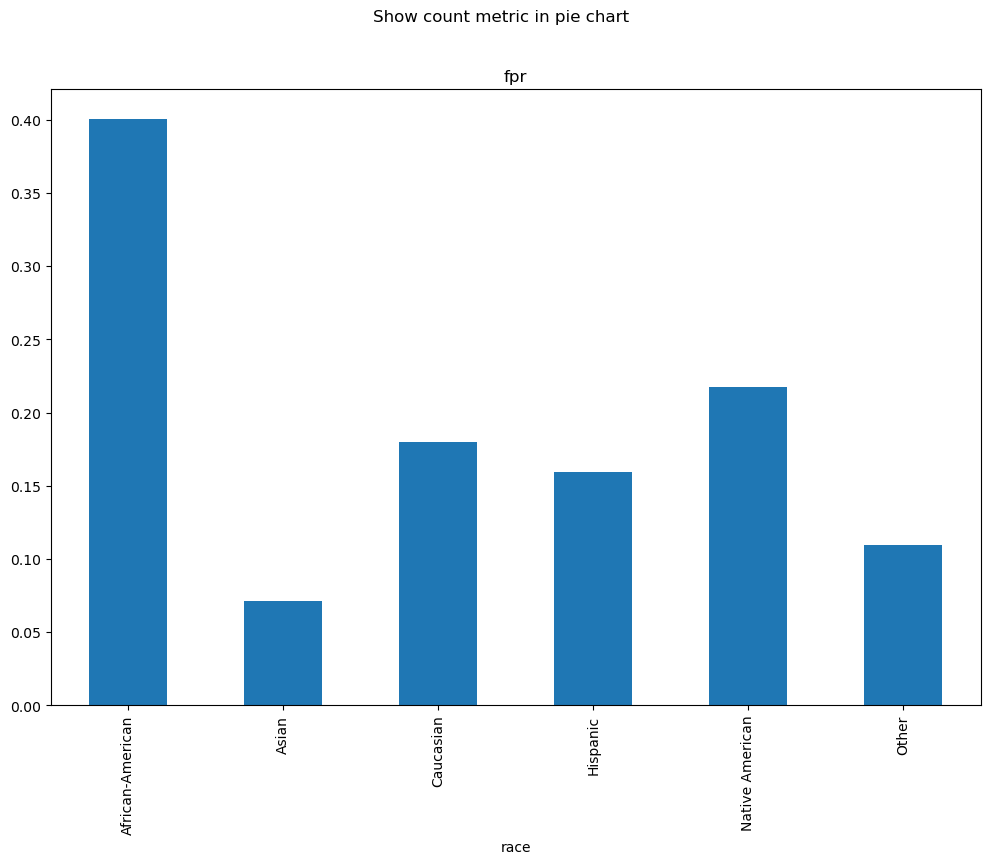

In [32]:
# Customize plots with kind (note that we are only plotting the "count" metric here because we are showing a pie chart)
metric_frame.by_group[["fpr"]].plot(
    kind="bar",
    subplots=True,
    layout=[1, 1],
    legend=False,
    figsize=[12, 8],
    title="Show count metric in pie chart",
)

Based on this assessment, we see that false positive rates across groups are not equal. This means that COMPAS incorrectly predicts that defendants will recidivate at different rates across groups, meaning that some groups will be more incorrectly incarcereated than others.

### AI Fairness 360

In [1]:
from aif360 import explainers

pip install 'aif360[LawSchoolGPA]'


Apply fairness metrics with AI Fairness 360.

# Mitigating Bias

Bias mitigation comes in many forms. It can be applied pre-processing or post-processing.

We will not mitigate bias in the COMPAS model itself as we don't have access, however we can train a new model and mitigate bias within that model as a demonstration of how this can be applied in practice.

### Train a new model

We will need a new model as the beginning of producing recidivism predictions without bias. This is needed since all we have with COMPAS is the score and a suggestion of what the input data is. We do not have the model itself.

To do this we will use InterpretML, a python package for training AI models that are easier to interpret.

In [27]:
keep_cols = ['sex', 'race', 'age', 'age_cat', 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count', 'c_charge_degree', 'c_charge_desc', 'is_recid']
train_df = person_df[keep_cols]
#filter out rows with unknown recidivism
train_df = train_df[train_df['is_recid'] != -1]

In [28]:
train_df.head()

,sex,race,age,age_cat,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_degree,c_charge_desc,is_recid
0,Male,Other,69,Greater than 45,0,0,0,0,(F3),Aggravated Assault w/Firearm,0
2,Male,African-American,34,25 - 45,0,0,0,0,(F3),Felony Battery w/Prior Convict,1
3,Male,African-American,24,Less than 25,0,0,1,4,(F3),Possession of Cocaine,1
4,Male,African-American,23,Less than 25,0,1,0,1,(F3),Possession of Cannabis,0
5,Male,Other,43,25 - 45,0,0,0,2,(F7),arrest case no charge,0


In [33]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(train_df, test_size=0.2)

x_train = train.loc[:, train.columns != 'is_recid']
y_train = train.loc[:, train.columns == 'is_recid']

x_test = test.loc[:, test.columns != 'is_recid']
y_test = test.loc[:, test.columns == 'is_recid']

In [37]:
from interpret.glassbox import ExplainableBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

ebm = ExplainableBoostingClassifier()
ebm.fit(x_train, y_train)

c:\Users\chris\anaconda3\lib\site-packages\interpret\glassbox\_ebm\_ebm.py:666: UserWarning:

Missing values detected. Our visualizations do not currently display missing values. To retain the glassbox nature of the model you need to either set the missing values to an extreme value like -1000 that will be visible on the graphs, or manually examine the missing value score in ebm.term_scores_[term_index][0]



ExplainableBoostingClassifier()

In [38]:
#model performance
y_pred = ebm.predict(x_test)

In [40]:
# Assess the model's performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# Print the performance metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.7119565217391305
Precision: 0.6831470889653037
Recall: 0.6259236140876452
F1 Score: 0.6306418149758231


Observe the model's explainability.

In [ ]:
#explain the model
from interpret import show

ebm_global = ebm.explain_global()
show(ebm_global)

Observe individual prediction explainability.

In [ ]:
ebm_local = ebm.explain_local(x_test, y_test)
show(ebm_local)

Perform a fairness assessment.

In [46]:
from fairlearn.metrics import MetricFrame
from fairlearn.metrics import count, false_positive_rate, true_positive_rate, equalized_odds_difference

sf_data = x_test['race']

#common metrics
metrics = {
    'fpr' : false_positive_rate,
    'tpr' : true_positive_rate,
    'count' : count
}

metric_frame = MetricFrame(
    metrics=metrics,
    y_true = y_test,
    y_pred = y_pred,
    sensitive_features = sf_data
)


#equalised odds
eq_odds = equalized_odds_difference(y_test, y_pred,sensitive_features=sf_data)

In [47]:
eq_odds

0.3787878787878788

Equal odds show a difference in performance between groups.

In [48]:
metric_frame.by_group

,fpr,tpr,count
race,,,
African-American,0.165165,0.457207,1110.0
Asian,0.000000,0.500000,9.0
Caucasian,0.063670,0.234146,739.0
Hispanic,0.062069,0.171875,209.0
Native American,0.000000,0.333333,10.0
Other,0.000000,0.121212,131.0


There are significant disparities across groups for both false positive and true positive rates. From these we can observe that:
- African-Americans have the highest false positive rate, meaning that they are more likely to be incorrectly judged recidivist.
- Caucasian and Hispanic also show higher false positive rates, meaning they will be more likely to be incorrectly judged to be recidivist relative to Asian, Native American and Other
- True positive rates are varied